In [1]:
import jax.numpy as np
# from jax.config import config; config.update("jax_enable_x64", True)

import numpy as onp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.io.fits as pf
import xara
import xaosim as xs
from xaosim.pupil import PHARO

import astropy.io.fits as fits

from tqdm import tqdm
import pickle, gzip

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")

import os

In [2]:
# ddir = os.path.abspath(os.path.dirname("__file__"))
ddir = '/Users/benjaminpope/code/xara/xara/'
# -------------------------------
# 1. create the KP info structure
# -------------------------------

# once saved, the kpi.gz structure can be directly reloaded when 
# creating a KPO instance, such as done in step #2.

a = xara.KPI(ddir+"hst.txt")
a.name = "HST - NIC1" #  # add a label to the template
a.save_to_file('./hst.kpi.gz')


Attempting to load file /Users/benjaminpope/code/xara/xara/hst.txt
332 distinct baselines were identified
10 first singular values for this array:
[46.79691 46.33162 35.01308 34.70472 20.0892  19.939   16.52361 16.40732
 13.82746 13.76126]

        Summary of properties for hst.txt
        ---------------------------------------------------------------
        - 112 sub-apertures
        - 332 distinct baselines
        - 276 Ker-phases (83.1 % target phase information recovery)
        -  56 Eig-phases (50.0 % wavefront information recovery)
        ---------------------------------------------------------------
        
KPI data successfully loaded


0

In [3]:
ls ../data

n8yj25010/ n8yj25020/ n8yj56010/ n8yj56020/


In [4]:
# -------------------
# 2. load the dataset
# -------------------

# load the FITS frame, and extract the Kernel-phases using the
# HST KPI template calculated at the previous step. 
# Two data sets are provided:
# n8yj59010_mos.fits.gz and 'n8yj59020_mos.fits.gz

a = xara.KPO('./hst.kpi.gz')
# a = xara.KPO('hstmorphine_32bit_64pix.kpi.gz')
a.extract_KPD(ddir+'/n8yj59010_mos.fits.gz', wrad=50)
a.kpi.name = "2M XXXX-XX" #  # labels the data


Attempting to load file ./hst.kpi.gz
KPI data successfully loaded
File provided is not a fits file
The data comes from HST
1 data fits files will be opened
First time for m2pix = 15.68: 
LDFT1: Computing new Fourier matrix...
Done!
File /Users/benjaminpope/code/xara/xara//n8yj59010_mos.fits.gz, slice  1


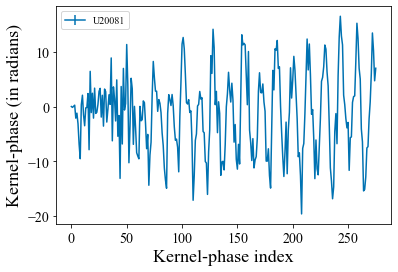

In [5]:
a.plot_KPD()

In [46]:

# ------------------------
# 2. model fit of the data
# ------------------------
import xara.fitting as fit

# binary_KPD_fit uses scipy's leastsq procedure, which is ita an 
# implementation of Levenberg-Marquardt Algorithm (LMA) to minimize the
# variance between the data and a binary-star model. Just like every
# implementation of LMA, you need to provide a initial set of
# parameters.
# it returns the best fit parameters, and a covariance matrix that can
# be used to determine uncertainties on the fit.

mydata = a.KPDT[0][0]
myerr = np.median(np.abs(mydata))/50.

params0 = [150.0, 80.0, 2.0]    # initial parameters for model-fit
optim   = a.binary_model_fit(params0)
params  = optim[0]    # best fit parameters (after least square)



computing colinearity map...
max colinearity found for sep = 152.97 mas and ang = -11.31 deg


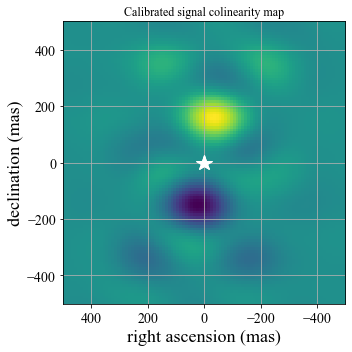

In [30]:
print("\ncomputing colinearity map...")
gsize = 100 # gsize x gsize grid
gstep = 10 # grid step in mas
xx, yy = np.meshgrid(
        np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

#mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
mmap = a.kpd_binary_match_map(100, 10, mydata, norm=True)
x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))

f1 = plt.figure(figsize=(5,5))
ax1 = f1.add_subplot(111)
ax1.imshow(mmap, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("Calibrated signal colinearity map")
ax1.grid()
f1.set_tight_layout(True)
f1.canvas.draw()


In [39]:
from scipy.optimize import leastsq

def binary_model(params,kpo):
    u = kpo.kpi.UVC[:,0]
    v = kpo.kpi.UVC[:,1]
    wl = kpo.CWAVEL
    detpa = 0
    return(xara.core.cvis_binary(u,v,wl, params, detpa))


def ben_binary_model_fit_residuals(params,kpo=a,index=0,obs="KERNEL"):
    temp = binary_model(params,kpo)
    model = kpo.kpi.KPM.dot(np.angle(temp))
    error = mydata-model
    error /= (myerr)
    return onp.array(error) 


def ben_binary_model_fit(p0,kpo=a,index=0,obs='KERNEL'):
    soluce = leastsq(ben_binary_model_fit_residuals, 
                 p0, args=((kpo,index, obs,)), full_output=1)

    return soluce



binary model fitting...
sep = 140.641409, ang=349.074219, con=2.075557 => chi2 = 3.817
correlation matrix of parameters
[[0.01 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]


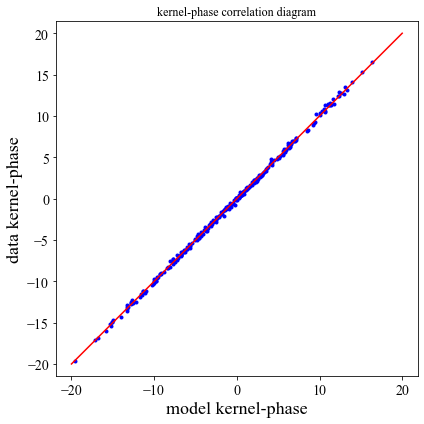

In [47]:
print("\nbinary model fitting...")
p0 = params0 # good starting point
p0 =  [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point
p0[1] = np.mod(p0[1],360.)

wl = a.CWAVEL

# mfit = a.binary_model_fit(p0)
mfit = ben_binary_model_fit(p0,kpo=a)


p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
p1[1] = np.mod(p1[1],360.)
# p1 = p0


cvis_b = xara.core.cvis_binary(
        a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p1) # binary
ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(ker_theo, mydata, yerr=myerr, fmt="none", ecolor='c')
ax.plot(ker_theo, mydata, 'b.')
mmax = np.round(np.abs(mydata).max())
ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
ax.set_ylabel("data kernel-phase")
ax.set_xlabel("model kernel-phase")
ax.set_title('kernel-phase correlation diagram')
ax.axis("equal")
# ax.axis([-11, 11, -11, 11])
fig.set_tight_layout(True)

if myerr is not None:
        chi2 = np.sum(((mydata - ker_theo)/myerr)**2) / a.kpi.nbkp
else:
        chi2 = np.sum(((mydata - ker_theo))**2) / a.kpi.nbkp

print("sep = %3f, ang=%3f, con=%3f => chi2 = %.3f" % (p1[0], p1[1], p1[2], chi2))
print("correlation matrix of parameters")
print(np.round(mfit[1], 2))
